In [75]:
import yaml
import wandb
from torch import cuda
from transformers import pipeline
from utils.data_utils import read_data, filter_fallacies, encode_labels, plot_training_curve, get_file_name
from transformers import BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from model.BERT import compute_metrics_wandb, DataLoader
from transformers import BertTokenizerFast, BertTokenizer

In [76]:
# Load configuration file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

    # Start a new wandb run to track this script
run = wandb.init(
    project="Logical_Fallacies",
    config=config,
    allow_val_change=True,  # Allows you to update the config during the run
    magic=False,  # Disables wandb's automatic logging of system metrics
    settings=wandb.Settings(console="off")
)

In [83]:
train_dataset, test_dataset, dev_dataset = read_data('data/combined_lfud_huggingface.csv')
dev_dataset.head()

,logical_fallacies,source_article_ro
4107,intentional,"Nimeni nu știe unde îmi sunt cheile, așa că tr..."
4108,deductive fallacy,"Dacă mi-am lăsat cheile în mașină, atunci nu î..."
4109,faulty generalization,Tom se antrenează pentru un maraton. Tom este ...
4110,false causality,Tom se antrenează pentru un maraton și a slăbi...
4111,circular reasoning,Tom se antrenează pentru un maraton pentru că ...


In [84]:
dev_dataset['logical_fallacies'].value_counts()

,count
logical_fallacies,
intentional,39
deductive fallacy,39
faulty generalization,38
false causality,38
circular reasoning,38
ad populum,38
false dilemma,38
fallacy of relevance,38
ad hominem,38


In [85]:
train_dataset['logical_fallacies'].value_counts()

,count
logical_fallacies,
faulty generalization,534
intentional,392
ad hominem,376
ad populum,284
appeal to emotion,276
false causality,266
fallacy of credibility,243
fallacy of relevance,242
fallacy of logic,222


In [86]:
test_dataset['logical_fallacies'].value_counts()

,count
logical_fallacies,
intentional,116
faulty generalization,69
appeal to emotion,61
fallacy of extension,60
false causality,52
fallacy of relevance,52
ad hominem,51
fallacy of credibility,49
false dilemma,47


In [87]:
logical_fallacies = ['faulty generalization', 'intentional', 'ad hominem']
fil_train_data, fil_test_data, fil_dev_data = filter_fallacies(train_dataset, test_dataset, dev_dataset,
                                                               ['faulty generalization', 'intentional', 'ad hominem'])
fil_train_data.head()

,logical_fallacies,source_article_ro
6,faulty generalization,Dacă interzicem Hummer-urile pentru că sunt dă...
8,faulty generalization,"""Ai întârziat în seara asta. Trebuie să înșeli!"""
11,ad hominem,Vă opuneți propunerii unui senator de a extind...
27,faulty generalization,Toți jucătorii de fotbal sunt proști.
28,faulty generalization,"""Verișoara mea a spus că cursul ei de matemati..."


In [88]:
id2label = {id: label for id, label in enumerate(logical_fallacies)}

label2id = {label: id for id, label in enumerate(logical_fallacies)}

print(label2id, id2label)

{'faulty generalization': 0, 'intentional': 1, 'ad hominem': 2} {0: 'faulty generalization', 1: 'intentional', 2: 'ad hominem'}


In [89]:
train_data, test_data, dev_data = encode_labels(fil_train_data, fil_test_data, fil_dev_data, label2id)

train_data shape: (1302, 3)
test_data shape: (236, 3)
dev_data shape: (115, 3)


In [90]:
# ro-bert
tokenizer = BertTokenizer.from_pretrained("dumitrescustefan/bert-base-romanian-uncased-v1", max_length=512)

In [91]:
device = 'cuda' if cuda.is_available() else 'cpu'
model = BertForSequenceClassification.from_pretrained("dumitrescustefan/bert-base-romanian-uncased-v1",
                                                      num_labels=len(logical_fallacies),
                                                      id2label=id2label, label2id=label2id)

# Make model weights contiguous
for name, param in model.named_parameters():
    if not param.is_contiguous():
        param.data = param.data.contiguous()
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dumitrescustefan/bert-base-romanian-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [92]:
train_encodings = tokenizer(list(train_data['source_article_ro']), padding=True, truncation=True, max_length=1024)
test_encodings = tokenizer(list(test_data['source_article_ro']), padding=True, truncation=True, max_length=1024)
dev_encodings = tokenizer(list(dev_data['source_article_ro']), padding=True, truncation=True, max_length=1024)

In [93]:
train_labels = list(train_data['logical_fallacies_id'])
test_labels = list(test_data['logical_fallacies_id'])
dev_labels = list(dev_data['logical_fallacies_id'])

In [94]:
train_dataloader = DataLoader(train_encodings, train_labels)
test_dataloader = DataLoader(test_encodings, test_labels)
dev_dataloader = DataLoader(dev_encodings, dev_labels)

In [96]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=float(config['model']['params']['learning_rate']),
    per_device_train_batch_size=config['model']['params']['train_batch_size'],
    per_device_eval_batch_size=config['model']['params']['eval_batch_size'],
    num_train_epochs=config['model']['params']['epochs'],
    weight_decay=0.01,
    log_level="warning"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=dev_dataloader,
    compute_metrics=compute_metrics_wandb
)

In [97]:
# Start training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.820626,0.634783,0.591378,0.744610,0.638327
2,No log,0.591634,0.782609,0.779894,0.830065,0.784076
3,No log,0.566770,0.808696,0.803848,0.841880,0.810391
4,No log,0.531678,0.834783,0.833127,0.855919,0.835807
5,No log,0.570989,0.826087,0.824510,0.849743,0.827036


TrainOutput(global_step=410, training_loss=0.42822139088700456, metrics={'train_runtime': 402.2218, 'train_samples_per_second': 16.185, 'train_steps_per_second': 1.019, 'total_flos': 1160869760244180.0, 'train_loss': 0.42822139088700456, 'epoch': 5.0})

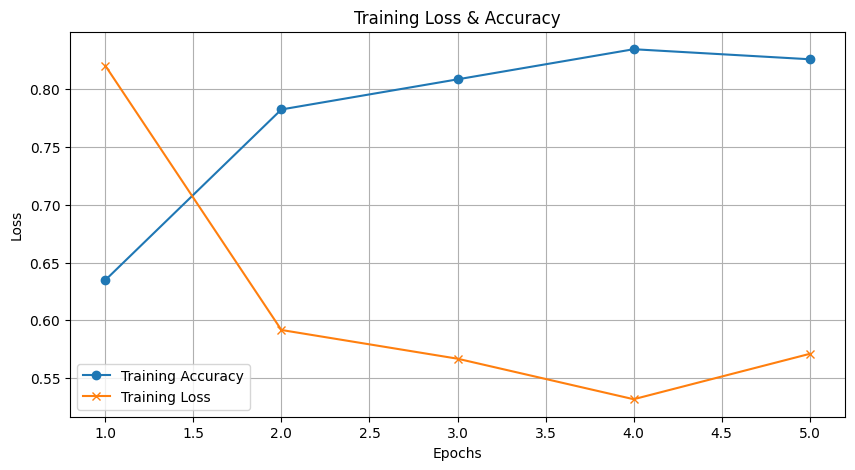

In [98]:
plot = plot_training_curve(trainer)

In [99]:
wandb.finish()

Accuracy_class_0,▁▁▁▁▁
Accuracy_class_1,▁▇▇██
Accuracy_class_2,▁▄█▇▅
F1_class_0,▁▅▇█▇
F1_class_1,▁▇▇██
F1_class_2,▁▆▇█▇
Precision_class_0,▁▅▇█▇
Precision_class_1,███▁▁
Precision_class_2,▁▇▆██
Recall_class_0,▁▁▁▁▁
Recall_class_1,▁▇▇██


In [100]:
model_path = get_file_name("outputs", "bert-3-classes-model")
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('outputs/12-11-2024_19-21-56_bert-3-classes-model.pickle/tokenizer_config.json',
 'outputs/12-11-2024_19-21-56_bert-3-classes-model.pickle/special_tokens_map.json',
 'outputs/12-11-2024_19-21-56_bert-3-classes-model.pickle/vocab.txt',
 'outputs/12-11-2024_19-21-56_bert-3-classes-model.pickle/added_tokens.json')

In [101]:
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)
nlp = pipeline("text-classification", model=model, tokenizer=tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
